In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

# ==========================================
# 1. CONFIGURATION (OPTIMIZED FOR 1 HOUR)
# ==========================================
# Paths
BASE_DIR = os.getcwd()
SCENARIO_DIR = os.path.join(BASE_DIR, "Network with RL control")
RESULTS_DIR = os.path.join(SCENARIO_DIR, "results")
MODEL_DIR = os.path.join(SCENARIO_DIR, "models")
CONFIG_PATH = os.path.join(SCENARIO_DIR, "ff_heterogeneous.sumocfg")

# Hyperparameters
NUM_EPISODES = 500          # Fits within 1 hour
MAX_STEPS = 900             # 15 minutes simulated per episode (enough to learn congestion)
BATCH_SIZE = 32             # Faster processing
MEMORY_SIZE = 20000
GAMMA = 0.95                # Discount factor
LEARNING_RATE = 0.002       # Slightly higher learning rate for faster convergence

# Exploration Settings
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.99        # Reaches minimal exploration around episode 300

# Traffic Settings
TLS_IDS = ["E1", "E2", "E3", "E4"]
YELLOW_DURATION = 3
MIN_GREEN = 10

# Hardware Check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- TRAINING CONFIGURATION ---")
print(f"Device: {device}")
print(f"Target Time: ~1 Hour")
print(f"Episodes: {NUM_EPISODES}")
print(f"Steps per Episode: {MAX_STEPS}")
print("------------------------------")

# ==========================================
# 2. NEURAL NETWORK (DQN)
# ==========================================
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        # Lighter network for faster training on normal PC
        self.fc = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )

    def forward(self, x):
        return self.fc(x)

# ==========================================
# 3. RL AGENT
# ==========================================
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.epsilon = EPSILON_START
        
        self.policy_net = DQN(state_size, action_size).to(device)
        self.target_net = DQN(state_size, action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LEARNING_RATE)
        self.criterion = nn.MSELoss()

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.policy_net(state_tensor)
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return

        minibatch = random.sample(self.memory, BATCH_SIZE)
        
        states = torch.FloatTensor(np.array([m[0] for m in minibatch])).to(device)
        actions = torch.LongTensor([m[1] for m in minibatch]).unsqueeze(1).to(device)
        rewards = torch.FloatTensor([m[2] for m in minibatch]).to(device)
        next_states = torch.FloatTensor(np.array([m[3] for m in minibatch])).to(device)
        dones = torch.FloatTensor([m[4] for m in minibatch]).to(device)

        curr_Q = self.policy_net(states).gather(1, actions).squeeze(1)
        
        with torch.no_grad():
            next_Q = self.target_net(next_states).max(1)[0]
            target_Q = rewards + (GAMMA * next_Q * (1 - dones))

        loss = self.criterion(curr_Q, target_Q)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def save(self, path):
        torch.save(self.policy_net.state_dict(), path)

# ==========================================
# 4. SUMO HELPER FUNCTIONS
# ==========================================
def check_sumo_env():
    if 'SUMO_HOME' not in os.environ:
        sys.exit("Error: SUMO_HOME environment variable is not set.")
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
    os.makedirs(RESULTS_DIR, exist_ok=True)
    os.makedirs(MODEL_DIR, exist_ok=True)
    
    # Ensure config file exists
    if not os.path.exists(CONFIG_PATH):
        import shutil
        print("Config file not found, attempting to copy from 'Original network'...")
        original_dir = os.path.join(BASE_DIR, "Original network")
        for file in ["ff_heterogeneous.sumocfg", "ff.net.xml", "ff_heterogeneous.rou.xml"]:
            src = os.path.join(original_dir, file)
            dst = os.path.join(SCENARIO_DIR, file)
            if os.path.exists(src):
                shutil.copy(src, dst)
    return tools

tools_path = check_sumo_env()
import traci

def get_sumo_binary():
    # Always headless for performance
    return os.path.join(os.environ['SUMO_HOME'], 'bin', 'sumo') 

def get_state(tls_id):
    """
    State (Size 3):
    1. Total Queue Length (Normalized)
    2. Max Queue Length (Normalized)
    3. Current Phase Index (Normalized)
    """
    lanes = traci.trafficlight.getControlledLanes(tls_id)
    halting = [traci.lane.getLastStepHaltingNumber(lane) for lane in lanes]
    
    total_queue = sum(halting) / 50.0  # Normalized
    max_queue = max(halting) / 20.0    # Normalized
    phase = traci.trafficlight.getPhase(tls_id) / 4.0
    
    return np.array([total_queue, max_queue, phase], dtype=np.float32)

def get_reward(tls_id, waiting_time_prev):
    """
    Reward function CLIPPED to prevent huge numbers.
    """
    lanes = traci.trafficlight.getControlledLanes(tls_id)
    current_wait = sum([traci.lane.getWaitingTime(lane) for lane in lanes])
    current_queue = sum([traci.lane.getLastStepHaltingNumber(lane) for lane in lanes])
    
    # Reward = (WaitTime Reduction) - (Queue Penalty)
    diff = waiting_time_prev - current_wait
    
    # Scaling to keep reward small (e.g., between -5 and 5)
    reward = (diff * 0.2) - (current_queue * 0.05)
    
    # CLAMPING: Crucial for stability
    reward = max(min(reward, 5.0), -5.0)
    
    return reward, current_wait

# ==========================================
# 5. MAIN TRAINING LOOP
# ==========================================
def train():
    # Input: 3, Output: 2
    agent = DQNAgent(state_size=3, action_size=2)
    sumo_bin = get_sumo_binary()
    
    print("\nStarting Optimized Training...")

    for episode in range(NUM_EPISODES):
        # Start SUMO
        sumo_cmd = [sumo_bin, "-c", CONFIG_PATH, "--no-step-log", "true", "--waiting-time-memory", "1000"]
        try:
            traci.start(sumo_cmd)
        except Exception as e:
            print(f"Error starting SUMO: {e}")
            break

        step = 0
        total_reward = 0
        
        # Tracking data for all 4 intersections
        tls_data = {t: {"prev_wait": 0, "phase_time": 0} for t in TLS_IDS}

        while step < MAX_STEPS:
            traci.simulationStep()
            step += 1
            
            # Make decisions every 5 seconds (not every step)
            if step % 5 == 0:
                for tls in TLS_IDS:
                    # 1. Observe State
                    state = get_state(tls)
                    
                    # 2. Select Action
                    action = agent.act(state)
                    
                    # 3. Apply Action (Logic)
                    current_phase = traci.trafficlight.getPhase(tls)
                    
                    # Phase 0=NS Green, 1=Yellow, 2=EW Green, 3=Yellow
                    # Action 0=NS Green, Action 1=EW Green
                    
                    if current_phase == 1 or current_phase == 3:
                        # Yellow phase logic: wait it out
                        tls_data[tls]["phase_time"] += 5
                        if tls_data[tls]["phase_time"] >= YELLOW_DURATION:
                            next_phase = 2 if current_phase == 1 else 0
                            traci.trafficlight.setPhase(tls, next_phase)
                            tls_data[tls]["phase_time"] = 0
                    else:
                        # Green phase logic
                        target_phase = 0 if action == 0 else 2
                        
                        if current_phase != target_phase:
                            # We want to switch
                            if tls_data[tls]["phase_time"] >= MIN_GREEN:
                                traci.trafficlight.setPhase(tls, current_phase + 1) # Go Yellow
                                tls_data[tls]["phase_time"] = 0
                            else:
                                tls_data[tls]["phase_time"] += 5 # Keep Green
                        else:
                            tls_data[tls]["phase_time"] += 5 # Keep Green
                    
                    # 4. Reward & Learn
                    reward, new_wait = get_reward(tls, tls_data[tls]["prev_wait"])
                    
                    # Remember
                    next_state = get_state(tls)
                    agent.remember(state, action, reward, next_state, False)
                    
                    tls_data[tls]["prev_wait"] = new_wait
                    total_reward += reward

                # Train Agent
                agent.replay()

        traci.close()
        
        # Update Target Net
        if episode % 5 == 0:
            agent.update_target_network()
            
        # Decay Epsilon
        if agent.epsilon > EPSILON_END:
            agent.epsilon *= EPSILON_DECAY

        print(f"Ep {episode+1}/{NUM_EPISODES} | Reward: {total_reward:.2f} | Eps: {agent.epsilon:.2f}")

        # Autosave
        if (episode + 1) % 25 == 0:
            agent.save(os.path.join(MODEL_DIR, f"model_ep{episode+1}.pth"))

    agent.save(os.path.join(MODEL_DIR, "final_model.pth"))
    print("Training Completed.")

if __name__ == "__main__":
    train()

--- TRAINING CONFIGURATION ---
Device: cuda
Target Time: ~1 Hour
Episodes: 500
Steps per Episode: 900
------------------------------

Starting Optimized Training...
Ep 1/500 | Reward: -594.85 | Eps: 0.99
Ep 2/500 | Reward: -578.00 | Eps: 0.98
Ep 3/500 | Reward: -607.90 | Eps: 0.97
Ep 4/500 | Reward: -497.30 | Eps: 0.96
Ep 5/500 | Reward: -504.60 | Eps: 0.95
Ep 6/500 | Reward: -699.90 | Eps: 0.94
Ep 7/500 | Reward: -640.15 | Eps: 0.93
Ep 8/500 | Reward: -600.45 | Eps: 0.92
Ep 9/500 | Reward: -626.10 | Eps: 0.91
Ep 10/500 | Reward: -607.85 | Eps: 0.90
Ep 11/500 | Reward: -660.85 | Eps: 0.90
Ep 12/500 | Reward: -558.25 | Eps: 0.89
Ep 13/500 | Reward: -605.75 | Eps: 0.88
Ep 14/500 | Reward: -804.25 | Eps: 0.87
Ep 15/500 | Reward: -613.70 | Eps: 0.86
Ep 16/500 | Reward: -628.00 | Eps: 0.85
Ep 17/500 | Reward: -566.00 | Eps: 0.84
Ep 18/500 | Reward: -630.45 | Eps: 0.83
Ep 19/500 | Reward: -684.20 | Eps: 0.83
Ep 20/500 | Reward: -604.15 | Eps: 0.82
Ep 21/500 | Reward: -726.15 | Eps: 0.81
Ep 2

time 1h30

Found 20 models. Starting evaluation...
Testing model: model_ep25.pth...
 -> Ep 25: Score -1480.05
Testing model: model_ep50.pth...
 -> Ep 50: Score -1293.60
Testing model: model_ep75.pth...
 -> Ep 75: Score -1283.35
Testing model: model_ep100.pth...
 -> Ep 100: Score -344.30
Testing model: model_ep125.pth...
 -> Ep 125: Score -135.70
Testing model: model_ep150.pth...
 -> Ep 150: Score -223.90
Testing model: model_ep175.pth...
 -> Ep 175: Score -135.70
Testing model: model_ep200.pth...
 -> Ep 200: Score -135.70
Testing model: model_ep225.pth...
 -> Ep 225: Score -210.10
Testing model: model_ep250.pth...
 -> Ep 250: Score -135.70
Testing model: model_ep275.pth...
 -> Ep 275: Score -135.70
Testing model: model_ep300.pth...
 -> Ep 300: Score -135.70
Testing model: model_ep325.pth...
 -> Ep 325: Score -135.70
Testing model: model_ep350.pth...
 -> Ep 350: Score -135.70
Testing model: model_ep375.pth...
 -> Ep 375: Score -135.70
Testing model: model_ep400.pth...
 -> Ep 400: Score -135.70
Tes

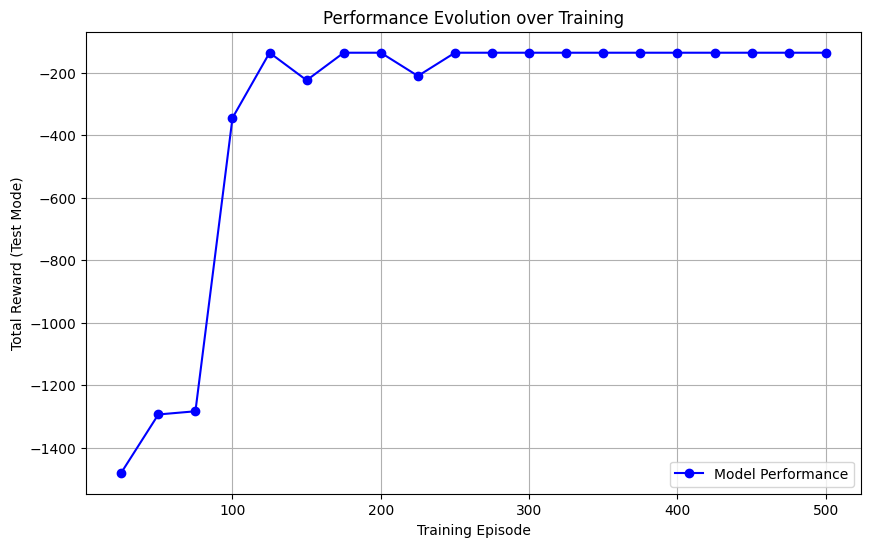

In [1]:
import os
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import re
import glob

# ==========================================
# 1. CONFIGURATION
# ==========================================
BASE_DIR = os.getcwd()
SCENARIO_DIR = os.path.join(BASE_DIR, "Network with RL control")
MODEL_DIR = os.path.join(SCENARIO_DIR, "models")
CONFIG_PATH = os.path.join(SCENARIO_DIR, "ff_heterogeneous.sumocfg")
TLS_IDS = ["E1", "E2", "E3", "E4"]
MAX_STEPS = 900  # Same duration as training
YELLOW_DURATION = 3
MIN_GREEN = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================
# 2. DEFINE THE NETWORK (Must match training)
# ==========================================
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        # Ensure this architecture matches your training script exactly!
        self.fc = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )

    def forward(self, x):
        return self.fc(x)

# ==========================================
# 3. SUMO UTILS
# ==========================================
if 'SUMO_HOME' not in os.environ:
    sys.exit("Please set SUMO_HOME environment variable.")
tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
sys.path.append(tools)
import traci

def get_sumo_binary():
    return os.path.join(os.environ['SUMO_HOME'], 'bin', 'sumo') # Headless for speed

def get_state(tls_id):
    lanes = traci.trafficlight.getControlledLanes(tls_id)
    halting = [traci.lane.getLastStepHaltingNumber(lane) for lane in lanes]
    total_queue = sum(halting) / 50.0
    max_queue = max(halting) / 20.0
    phase = traci.trafficlight.getPhase(tls_id) / 4.0
    return np.array([total_queue, max_queue, phase], dtype=np.float32)

def get_reward(tls_id, waiting_time_prev):
    lanes = traci.trafficlight.getControlledLanes(tls_id)
    current_wait = sum([traci.lane.getWaitingTime(lane) for lane in lanes])
    current_queue = sum([traci.lane.getLastStepHaltingNumber(lane) for lane in lanes])
    diff = waiting_time_prev - current_wait
    reward = (diff * 0.2) - (current_queue * 0.05)
    return max(min(reward, 5.0), -5.0), current_wait

# ==========================================
# 4. EVALUATION LOGIC
# ==========================================
def evaluate_model(model_path):
    """Loads a model and runs one simulation episode to get the score."""
    print(f"Testing model: {os.path.basename(model_path)}...")
    
    # Load Model
    model = DQN(3, 2).to(device)
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval() # Set to evaluation mode
    except Exception as e:
        print(f"Failed to load {model_path}: {e}")
        return None

    # Start SUMO
    sumo_cmd = [get_sumo_binary(), "-c", CONFIG_PATH, "--no-step-log", "true", "--waiting-time-memory", "1000"]
    traci.start(sumo_cmd)
    
    step = 0
    total_reward = 0
    tls_data = {t: {"prev_wait": 0, "phase_time": 0} for t in TLS_IDS}

    while step < MAX_STEPS:
        traci.simulationStep()
        step += 1
        
        if step % 5 == 0:
            for tls in TLS_IDS:
                state = get_state(tls)
                
                # GREEDY ACTION (No Epsilon, pure brain)
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                with torch.no_grad():
                    action = torch.argmax(model(state_tensor)).item()

                current_phase = traci.trafficlight.getPhase(tls)
                
                # Logic (Must match training logic)
                if current_phase == 1 or current_phase == 3:
                    tls_data[tls]["phase_time"] += 5
                    if tls_data[tls]["phase_time"] >= YELLOW_DURATION:
                        next_phase = 2 if current_phase == 1 else 0
                        traci.trafficlight.setPhase(tls, next_phase)
                        tls_data[tls]["phase_time"] = 0
                else:
                    target_phase = 0 if action == 0 else 2
                    if current_phase != target_phase:
                        if tls_data[tls]["phase_time"] >= MIN_GREEN:
                            traci.trafficlight.setPhase(tls, current_phase + 1)
                            tls_data[tls]["phase_time"] = 0
                        else:
                            tls_data[tls]["phase_time"] += 5
                    else:
                        tls_data[tls]["phase_time"] += 5
                
                reward, new_wait = get_reward(tls, tls_data[tls]["prev_wait"])
                tls_data[tls]["prev_wait"] = new_wait
                total_reward += reward

    traci.close()
    return total_reward

# ==========================================
# 5. MAIN EXECUTION
# ==========================================
def main():
    # 1. Find all model files
    files = glob.glob(os.path.join(MODEL_DIR, "model_ep*.pth"))
    
    # 2. Extract episode numbers and sort them
    # Creates a list of tuples: (episode_number, file_path)
    models_to_test = []
    for f in files:
        match = re.search(r"model_ep(\d+).pth", f)
        if match:
            ep_num = int(match.group(1))
            models_to_test.append((ep_num, f))
    
    # Sort by episode number
    models_to_test.sort(key=lambda x: x[0])
    
    if not models_to_test:
        print("No models found! Check your folder path.")
        return

    print(f"Found {len(models_to_test)} models. Starting evaluation...")
    
    episodes = []
    rewards = []

    # 3. Test loop
    for ep_num, file_path in models_to_test:
        score = evaluate_model(file_path)
        if score is not None:
            episodes.append(ep_num)
            rewards.append(score)
            print(f" -> Ep {ep_num}: Score {score:.2f}")

    # 4. Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(episodes, rewards, marker='o', linestyle='-', color='b', label='Model Performance')
    
    plt.title('Performance Evolution over Training')
    plt.xlabel('Training Episode')
    plt.ylabel('Total Reward (Test Mode)')
    plt.grid(True)
    plt.legend()
    
    output_img = "model_evolution_graph.png"
    plt.savefig(output_img)
    print(f"\nDone! Graph saved to {output_img}")
    plt.show()

if __name__ == "__main__":
    main()